### Settings

In [1]:
import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train_ratings = pd.read_csv('../data/train_ratings.csv')
test_ratings = pd.read_csv('../data/test_ratings.csv')
books = pd.read_csv('../data/books.csv')
users = pd.read_csv('../data/users.csv')

In [3]:
# a,b,c,d 처럼 주소를 적은 사람들
sum(users.location.apply(lambda x : len(x.split(','))) > 3)

295

### def process_context_data 함수에서 EDA 진행

#### location 결측치 처리

In [72]:
# def process_context_data(users, books, ratings1, ratings2):
ratings1, ratings2 = train_ratings, test_ratings # 함수안에서는 제거해줘야 하는 코드
users['location'] = users['location'].str.replace(r'[^0-9a-zA-Z:,]', '') # 특수문자 제거
users['location_city'] = users['location'].apply(lambda x: x.split(',')[0].strip() if ((x.split(',')[0].strip()!='na' and x.split(',')[0].strip()!='' and len(x.split(',')) > 3
) or len(x.split(',')) == 3) else x.split(',')[-3].strip()) # 만약 location이 4개로 나눠지는데, 첫번째가 na가 아니거나, location이 3개로 밖에 안쪼개진다면 0번째 값, 아니면 뒤에서 3번째 값
users['location_state'] = users['location'].apply(lambda x: x.split(',')[1].strip() if len(x.split(',')) == 3 else x.split(',')[-2].strip())
users['location_country'] = users['location'].apply(lambda x: x.split(',')[2].strip() if len(x.split(',')) == 3 else x.split(',')[-1].strip())

users = users.replace('na', np.nan) #특수문자 제거로 n/a가 na로 바뀌게 되었습니다. 따라서 이를 컴퓨터가 인식할 수 있는 결측값으로 변환합니다.
users = users.replace('', np.nan) # 일부 경우 , , ,으로 입력된 경우가 있었으므로 이런 경우에도 결측값으로 변환합니다.

# location 결측치 대치
print(users.isna().sum())
isna_notnull = [('location_country', 'location_city'), ('location_state', 'location_city'), ('location_country', 'location_state')]
for a,b in isna_notnull:
    modify_location = list(set(users[(users[a].isna())&(users[b].notnull())][b].values))
    
    # location_list = []
    for location in tqdm.tqdm(modify_location):
        try:
            right_location = users[(users[b] == location)][a].value_counts().index[0]
            users.loc[(users[b] == location) & users[a].isna(), a] = right_location
            # location_list.append(right_location)
        except:
            pass
    # for location in location_list:
        # users.loc[users[users['location_city']==location.split(',')[0]].index,'location_state'] = location.split(',')[1]
        # users.loc[users[users[b]==location.split(',')[0]].index,a] = location.split(',')[2]

    print('-'*25)
    print(users.isna().sum())
    print('-'*25)
# us 대신 usa로 처리
users.loc[users['location_country'] == 'us', 'location_country'] = 'usa'
users = users.drop(['location'], axis=1)

ratings = pd.concat([ratings1, ratings2]).reset_index(drop=True)

# 인덱싱 처리된 데이터 조인
context_df = ratings.merge(users, on='user_id', how='left').merge(books[['isbn', 'category', 'publisher', 'language', 'book_author']], on='isbn', how='left')
train_df = ratings1.merge(users, on='user_id', how='left').merge(books[['isbn', 'category', 'publisher', 'language', 'book_author']], on='isbn', how='left')
test_df = ratings2.merge(users, on='user_id', how='left').merge(books[['isbn', 'category', 'publisher', 'language', 'book_author']], on='isbn', how='left')

/tmp/ipykernel_21930/393203891.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  users['location'] = users['location'].str.replace(r'[^0-9a-zA-Z:,]', '') # 특수문자 제거
  1%|          | 9/1160 [00:00<00:13, 87.87it/s]

user_id                 0
location                0
age                 27833
location_city         121
location_state       3216
location_country     2104
dtype: int64


  1%|          | 11/1543 [00:00<00:15, 98.48it/s]

-------------------------
user_id                 0
location                0
age                 27833
location_city         121
location_state       3216
location_country      166
dtype: int64
-------------------------


 21%|██▏       | 9/42 [00:00<00:00, 88.04it/s]

-------------------------
user_id                 0
location                0
age                 27833
location_city         121
location_state        475
location_country      166
dtype: int64
-------------------------


100%|██████████| 42/42 [00:00<00:00, 84.45it/s]


-------------------------
user_id                 0
location                0
age                 27833
location_city         121
location_state        475
location_country      121
dtype: int64
-------------------------


In [77]:
users.isna().sum()

user_id                 0
age                 27833
location_city         121
location_state        475
location_country      121
dtype: int64

In [76]:
age_missing = list(users[users['age'].isna()]['user_id'])
len(age_missing)

27833

#### age 결측치 처리 1: train_df 내에서 유저가 소비한 책중 5권을 골라 그 책을 소비한 사람의 연령의 중앙값들의 중앙값으로 대치

In [78]:
age_missing = list(users[users['age'].isna()]['user_id'])
isbn_groupby = train_df.groupby('isbn').median()
for uid in tqdm.tqdm(age_missing):
    isbn_of_uid = list(train_df[train_df['user_id'] == uid]['isbn'][:5]) # 유저가 읽은 책 5권
    median_ages = []  # 책 5권을 소비한 사람들의 나이의 중앙값을 저장할 리스트
    for isbn_book in isbn_of_uid:
        median_age_of_book = isbn_groupby.loc[isbn_book,'age'] # 한 권의 책에 대한 나이 중앙값
        if not pd.isna(median_age_of_book): # na가 아니면 리스트에 추가
            median_ages.append(median_age_of_book)
    modify_age = np.median(median_ages)
    users.loc[users['user_id'] == uid,'age'] = modify_age

  0%|          | 18/27833 [00:00<02:36, 178.29it/s]/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 27833/27833 [00:27<00:00, 1012.55it/s]


In [79]:
users.isna().sum()

user_id                0
age                 8523
location_city        121
location_state       475
location_country     121
dtype: int64

#### age 결측치 처리 2: 속한 나라의 중앙값으로 대치

In [81]:
country_median_age = users.groupby('location_country').median()
for idx, row in tqdm.tqdm(users[users['age'].isna() & users['location_country'].notnull()].iterrows()):
    row_country = row['location_country']
    modify_age = country_median_age.loc[row_country,'age']
    
    if not pd.isna(modify_age):
        users.loc[users['user_id'] == row['user_id'],'age'] = modify_age

8506it [00:03, 2834.15it/s]


In [82]:
users.isna().sum()

user_id               0
age                  35
location_city       121
location_state      475
location_country    121
dtype: int64

아직도 결측 상태인 35명에 대해서는 전체 평균 나이값을 넣어준다

In [86]:
users['age'] = users['age'].fillna(users['age'].mean())

In [107]:
users['location_city'] = users['location_city'].apply(lambda x : str(x))
users['location_state'] = users['location_state'].apply(lambda x : str(x))
users['location_country'] = users['location_country'].apply(lambda x : str(x))

In [113]:
users['location'] = users['location_city'] + ',' + users['location_state'] + ',' + users['location_country']

In [123]:
users = users.drop(['location_city', 'location_state', 'location_country'], axis=1)
users = users[['user_id', 'location', 'age']]
users.head(5)

,user_id,location,age
0,8,"timmins,ontario,canada",30.0
1,11400,"ottawa,ontario,canada",49.0
2,11676,"nan,nan,nan",33.0
3,67544,"toronto,ontario,canada",30.0
4,85526,"victoria,britishcolumbia,canada",36.0


In [124]:
users.isna().sum()

user_id     0
location    0
age         0
dtype: int64

#### 결측치 처리 후 data save, load (users_sj)

In [126]:
users.to_csv('./data/users_sj.csv',index=False)


## books.csv 전처리

In [4]:
books.head()

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
0,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
1,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,en,['1940-1949'],"Here, for the first time in paperback, is an o...",images/0060973129.01.THUMBZZZ.jpg
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,en,['Medical'],"Describes the great flu epidemic of 1918, an o...",images/0374157065.01.THUMBZZZ.jpg
3,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,en,['Fiction'],A Chinese immigrant who is convinced she is dy...,images/0399135782.01.THUMBZZZ.jpg
4,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000.0,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,en,['History'],"Essays by respected military historians, inclu...",images/0425176428.01.THUMBZZZ.jpg


In [5]:
books.isna().sum()

isbn                       0
book_title                 0
book_author                0
year_of_publication        0
publisher                  0
img_url                    0
language               67227
category               68851
summary                67227
img_path                   0
dtype: int64

### publisher

In [6]:
publisher_dict=(books['publisher'].value_counts()).to_dict()
publisher_count_df= pd.DataFrame(list(publisher_dict.items()),columns = ['publisher','count'])

publisher_count_df = publisher_count_df.sort_values(by=['count'], ascending = False)
publisher_count_df.head()

,publisher,count
0,Harlequin,3005
1,Ballantine Books,2322
2,Pocket,2274
3,Penguin Books,1943
4,Bantam Books,1938


In [7]:
books['publisher'].nunique() # 수정 전 출판사 개수

11571

In [8]:
modify_list = publisher_count_df[publisher_count_df['count']>1].publisher.values
for publisher in modify_list:
    try:
        number = books[books['publisher']==publisher]['isbn'].apply(lambda x: x[:4]).value_counts().index[0]
        right_publisher = books[books['isbn'].apply(lambda x: x[:4])==number]['publisher'].value_counts().index[0]
        books.loc[books[books['isbn'].apply(lambda x: x[:4])==number].index,'publisher'] = right_publisher
    except: 
        pass

In [9]:
books['publisher'].nunique() # 수정 후 출판사 개수

1523

In [10]:
publisher_dict=(books['publisher'].value_counts()).to_dict()
publisher_count_df= pd.DataFrame(list(publisher_dict.items()),columns = ['publisher','count'])

publisher_count_df = publisher_count_df.sort_values(by=['count'], ascending = False)
publisher_count_df.head()

,publisher,count
0,Pocket,7306
1,Harlequin,5268
2,Bantam Books,4815
3,St. Martin's Press,4043
4,Vintage Books USA,3822


In [11]:
import re

# 대괄호([,]) 제거
books.loc[books[books['category'].notnull()].index, 'category'] = books[books['category'].notnull()]['category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip())

#### category

In [12]:
# 카테고리 정리
books['category'] = books['category'].str.lower()
category_df = pd.DataFrame(books['category'].value_counts()).reset_index()
category_df.columns = ['category','count']
print(category_df.shape)
category_df.head()

(4105, 2)


,category,count
0,fiction,33016
1,juvenile fiction,5835
2,biography autobiography,3326
3,history,1927
4,religion,1818


- 상위 카테고리로 묶기 

In [13]:
books['category_high'] = books['category'].copy()
# books.loc[books[books['category']=='biography'].index, 'category_high'] = 'biography autobiography'
# books.loc[books[books['category']=='autobiography'].index,'category_high'] = 'biography autobiography'
books.loc[books[books['category'].str.contains('history',na=False)].index,'category_high'] = 'history'

categories = ['garden','crafts','physics','adventure','music','fiction','nonfiction','science','science fiction','social','homicide',
 'sociology','disease','religion','christian','philosophy','psycholog','mathemat','agricult','environmental',
 'business','poetry','drama','literary','travel','motion picture','children','cook','literature','electronic',
 'humor','animal','bird','photograph','computer','house','ecology','family','architect','camp','criminal','language','india','biography']

for category in categories:
    books.loc[books[books['category'].str.contains(category,na=False)].index,'category_high'] = category

In [14]:
category_high_df = pd.DataFrame(books['category_high'].value_counts()).reset_index()
category_high_df.columns = ['category','count']
print(category_df.shape)
category_high_df.head(10)

(4105, 2)


,category,count
0,fiction,39677
1,biography,3351
2,history,1949
3,religion,1824
4,nonfiction,1427
5,humor,1291
6,social,1271
7,business,1146
8,cook,1125
9,body mind spirit,1113


In [15]:
others_list = category_high_df[category_high_df['count']<10]['category'].values
books.loc[books[books['category_high'].isin(others_list)].index, 'category_high']='others'

In [16]:
books['category'].nunique(), books['category_high'].nunique()

(4105, 209)

In [19]:
books = books.drop(['category'], axis=1)
books = books[['isbn', 'book_title', 'book_author', 'year_of_publication', 'publisher',
       'img_url', 'language', 'category_high', 'summary', 'img_path',
       ]]
books.rename(columns = {'category_high':'category'},inplace=True)


In [20]:
books.sample(1)

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
31052,0061011479,Return with Honor,Captain Scott O'Grady,1996.0,HarperTorch,http://images.amazon.com/images/P/0061011479.0...,en,biography,An American pilot who was shot down over Bosni...,images/0061011479.01.THUMBZZZ.jpg


In [21]:
books.shape

(149570, 10)

In [17]:
books.isna().sum()

isbn                       0
book_title                 0
book_author                0
year_of_publication        0
publisher                  0
img_url                    0
language               67227
category               68851
summary                67227
img_path                   0
category_high          68851
dtype: int64

##### category, language 결측치 처리

- Category, language에 결측치가 너무 많다
- 작가와 연동해서 결측치를 처리해보자
- ex) 작가는 비슷한 장르(언어)의 책을 쓸 가능성이 높으니까, 그 작가가 가장 많이 쓴 장르(언어)로 대치하자

In [22]:
na_ct_isbn = list(books[books.category.isna()]['isbn'])
na_ct_isbn[:5]

['0671870432', '0887841740', '1552041778', '1558746218', '1567407781']

In [23]:
len(set(na_ct_isbn)), len(na_ct_isbn)

(68851, 68851)

In [24]:
tmp = books.loc[books['isbn']=='0671870432']['book_author'].values[0]
books.loc[books['book_author'] == tmp].language.value_counts().index[0]

'en'

In [25]:
for isbn in tqdm.tqdm(na_ct_isbn):
    author = books.loc[books['isbn']==isbn]['book_author'].values[0]
    try:
        modify_category = books.loc[books['book_author'] == author].category.value_counts().index[0]
        books.loc[books['isbn'] == isbn, 'category'] = modify_category
    except:
        pass

    try:
        modify_language = books.loc[books['book_author'] == author].language.value_counts().index[0]
        books.loc[books['isbn'] == isbn, 'language'] = modify_language
    except:
        pass
    

100%|██████████| 68851/68851 [48:13<00:00, 23.80it/s]


In [26]:
books.isna().sum()

isbn                       0
book_title                 0
book_author                0
year_of_publication        0
publisher                  0
img_url                    0
language               26198
category               27203
summary                67227
img_path                   0
dtype: int64

In [30]:
books.sample(5)

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
47826,0373872100,A Love Worth Waiting For,Jillian Hart,2003.0,Harlequin,http://images.amazon.com/images/P/0373872100.0...,en,fiction,A Love Worth Waiting For by Jillian Hart relea...,images/0373872100.01.THUMBZZZ.jpg
7626,0060989270,Tommy's Tale : A Novel,Alan Cumming,2003.0,Perennial,http://images.amazon.com/images/P/0060989270.0...,en,fiction,"Tommy is twenty-nine, lives and loves in Londo...",images/0060989270.01.THUMBZZZ.jpg
82574,0520206371,Mirror of Modernity: Invented Traditions of Mo...,Stephen Vlastos,1998.0,University of California Press,http://images.amazon.com/images/P/0520206371.0...,en,history,This collection of essays challenges the notio...,images/0520206371.01.THUMBZZZ.jpg
148084,0912365277,Washington Homes: Buying Selling and Investing...,Jim Stacey,1990.0,Pub Group West,http://images.amazon.com/images/P/0912365277.0...,NaN,NaN,NaN,images/0912365277.01.THUMBZZZ.jpg
1482,0385315279,The Fiery Cross,Diana Gabaldon,2001.0,Bantam Dell Pub Group,http://images.amazon.com/images/P/0385315279.0...,en,fiction,"In 1771, Scotman Jamie Fraser and his twentiet...",images/0385315279.01.THUMBZZZ.jpg


- 이럼에도 처리 안 된 데이터는, 작가의 책중에 정상적인 language와 category가 없는 경우임 (아래처럼)

In [28]:
books[books.category.isna()].sample()

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
139273,3257216920,Kuck Kuck. Noch mehr Kille Kille Geschichten.,Ernst W. Heine,1989.0,Diogenes Verlag,http://images.amazon.com/images/P/3257216920.0...,NaN,NaN,NaN,images/3257216920.01.THUMBZZZ.jpg


In [29]:
books[books.book_author == 'Ernst W. Heine']

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
1686,3442720001,Das Halsband der Taube.,Ernst W. Heine,1996.0,Goldmann,http://images.amazon.com/images/P/3442720001.0...,NaN,NaN,NaN,images/3442720001.01.THUMBZZZ.jpg
100888,3442728053,Das Glasauge. Neue Kille Kille Geschichten.,Ernst W. Heine,2001.0,Goldmann,http://images.amazon.com/images/P/3442728053.0...,NaN,NaN,NaN,images/3442728053.01.THUMBZZZ.jpg
139273,3257216920,Kuck Kuck. Noch mehr Kille Kille Geschichten.,Ernst W. Heine,1989.0,Diogenes Verlag,http://images.amazon.com/images/P/3257216920.0...,NaN,NaN,NaN,images/3257216920.01.THUMBZZZ.jpg


In [33]:
books[books.book_author == 'Su>skind-Sempe']

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
138,2070567842,Folio Junior: L'histoire De Monsieur Sommer,Su>skind-Sempe,1994.0,Gallimard,http://images.amazon.com/images/P/2070567842.0...,fr,NaN,Un petit garçon se pose énormément de question...,images/2070567842.01.THUMBZZZ.jpg


- 결측치는 string 데이터로 nan으로 저장해주자

In [36]:
books['language'] = books['language'].apply(lambda x : str(x))
books['category'] = books['category'].apply(lambda x : str(x))
books['summary'] = books['summary'].apply(lambda x : str(x))

In [37]:
books.isna().sum()

isbn                   0
book_title             0
book_author            0
year_of_publication    0
publisher              0
img_url                0
language               0
category               0
summary                0
img_path               0
dtype: int64

##### 데이터 저장

In [38]:
books.to_csv('./data/books_sj.csv', index=False)

#### summary
- summary는 text 데이터 쓰지 않는이상 의미 없다고 생각
- 만약 text 데이터 쓰려면 title 값을 그대로 넣는 것도 생각
    - 그럼 title이 두개라서 의미 없는거 아닌가? => 아닌듯. 왜냐하면 src/data/text_data.py 에서, title 값은 사용 안하고 summary 값만 사용하는거 확인

In [32]:
books[books.category.isna() & books.language.notnull()]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
138,2070567842,Folio Junior: L'histoire De Monsieur Sommer,Su>skind-Sempe,1994.0,Gallimard,http://images.amazon.com/images/P/2070567842.0...,fr,NaN,Un petit garçon se pose énormément de question...,images/2070567842.01.THUMBZZZ.jpg
978,2266033689,Le Diable Au Corps,Raymond Radiguet,1994.0,Pocket,http://images.amazon.com/images/P/2266033689.0...,fr,NaN,NaN,images/2266033689.01.THUMBZZZ.jpg
1197,349913358X,Das Schlampenbuch. ErzÃ?Â¤hlungen. ( neue frau).,Milena Moser,1993.0,Rowohlt Tb.,http://images.amazon.com/images/P/349913358X.0...,de,NaN,"Grotesk bissige Erzählungen über Frauen, die k...",images/349913358X.01.THUMBZZZ.jpg
1230,0449131548,All the Days of My Life,Hilary Bailey,1986.0,Fawcett Books,http://images.amazon.com/images/P/0449131548.0...,en,NaN,NaN,images/0449131548.01.THUMBZZZ.jpg
1431,3492265014,Elfenfeuer.,Monika Felten,2003.0,Piper,http://images.amazon.com/images/P/3492265014.0...,de,NaN,"Deutsche Autorin, geb. 1965.",images/3492265014.01.THUMBZZZ.jpg
...,...,...,...,...,...,...,...,...,...,...
149141,3805206186,Die AffÃ?Â¤re Semmeling. Der Roman zum neuen Z...,Dieter Wedel,2001.0,Wunderlich im Rowohlt,http://images.amazon.com/images/P/3805206186.0...,de,NaN,NaN,images/3805206186.01.THUMBZZZ.jpg
149251,3770401654,"Lucky Luke, Bd.54, Die Daltons und der Psycho-Doc",Morris,1989.0,DUMONT Literatur und Kunst Verlag,http://images.amazon.com/images/P/3770401654.0...,de,NaN,"Mustercowboy Lucky Luke erlebt, wie Psycho-Doc...",images/3770401654.01.THUMBZZZ.jpg
149252,3770401697,"Lucky Luke, Bd.58, Die Geister-Ranch und ander...",Michel Janvier,1989.0,DUMONT Literatur und Kunst Verlag,http://images.amazon.com/images/P/3770401697.0...,de,NaN,"Enth. noch: Die Hellseherin, Die Statue und Di...",images/3770401697.01.THUMBZZZ.jpg
149329,3426192543,Im FrÃ?Â¼hling singt zum letztenmal die Lerche.,Johannes Mario Simmel,1990.0,"Droemersche Verlagsanstalt Th. Knaur Nachf., G...",http://images.amazon.com/images/P/3426192543.0...,de,NaN,Eine Gruppe von Idealisten nimmt den Kampf geg...,images/3426192543.01.THUMBZZZ.jpg


## 주의!
- 이 아래부터는 전처리 전, 어떤 변수를 중점으로 보면 좋을지에 대한 테스트 코드이기 때문에, 여기부터는 코드를 돌리시지 마시고 그냥 눈으로만 보시면 됩니다

### location만 처리했던 train과 test를 이용하여 시각화 및 데이터 확인

In [2]:
train_df = pd.read_csv('train_location.csv')
test_df = pd.read_csv('test_location.csv')

- 원래 southkorea 라는 country는 검출 해낼 수 없었지만, 주소를 잘못 적은 경우 뒤에서 첫 번째를 나라로 할 수 있게끔 처리하니 확인 가능

In [45]:
train_df[train_df['location_state'] == 'seoul'].head()

,user_id,isbn,rating,age,location_city,location_state,location_country,category,publisher,language,book_author
4751,24746,0316666343,7,NaN,seoul,seoul,southkorea,NaN,"Little, Brown",NaN,Alice Sebold
14298,121184,0312995423,9,NaN,apo,seoul,southkorea,NaN,St. Martin's Press,NaN,Dan Brown
18841,129655,0060934417,8,26.0,seoul,seoul,southkorea,NaN,Perennial,NaN,Ann Patchett
29109,224829,0446606812,5,NaN,seoul,seoul,southkorea,['Fiction'],Warner Vision,en,Nicholas Sparks
70253,98236,0553573861,8,NaN,seoul,seoul,southkorea,['Fiction'],Bantam,en,Neal Stephenson


In [52]:
train_df.isna().sum()

user_id                  0
isbn                     0
rating                   0
age                  92662
location_city         7000
location_state        7003
location_country      5951
category            121221
publisher                0
language            119084
book_author              0
dtype: int64

---
---
---

In [99]:
isna_notnull = [('location_country', 'location_city'), ('location_state', 'location_city'), ('location_country', 'location_state')]
for a,b in isna_notnull:
    modify_location = list(set(train_df[(train_df[a].isna())&(train_df[b].notnull())][b].values))
    # location = users[(users['location'].str.contains('seattle'))&(users[a].notnull())]['location'].value_counts().index[0]
    # 바로 윗 줄의 location은 올바른 location 정보를 찾아주기 위함 인듯.
    # seattle, , usa 와 같은 데이터들이 존재하기는 했음(주 만 없는)

    # location_list = []
    for location in tqdm.tqdm(modify_location):
        try:
            right_location = train_df[(train_df[b] == location)][a].value_counts().index[0]
            train_df.loc[(train_df[b] == location) & train_df[a].isna(), a] = right_location
            # location_list.append(right_location)
        except:
            pass

    # for location in location_list:
        
        # users.loc[users[users['location_city']==location.split(',')[0]].index,'location_state'] = location.split(',')[1]
        # users.loc[users[users[b]==location.split(',')[0]].index,a] = location.split(',')[2]

    print('-'*25)
    print(train_df.isna().sum())
    print('-'*25)

  0%|          | 4/1409 [00:00<00:41, 34.07it/s]

-------------------------
user_id                  0
isbn                     0
rating                   0
age                  92662
location_city         7000
location_state       16196
location_country      6245
category            121221
publisher                0
language            119084
book_author              0
dtype: int64
-------------------------


100%|██████████| 1409/1409 [01:04<00:00, 21.87it/s]


-------------------------


  5%|▌         | 2/38 [00:00<00:02, 16.57it/s]

user_id                  0
isbn                     0
rating                   0
age                  92662
location_city         7000
location_state        7050
location_country      6245
category            121221
publisher                0
language            119084
book_author              0
dtype: int64
-------------------------


100%|██████████| 38/38 [00:02<00:00, 18.82it/s]


-------------------------
user_id                  0
isbn                     0
rating                   0
age                  92662
location_city         7000
location_state        7050
location_country      5981
category            121221
publisher                0
language            119084
book_author              0
dtype: int64
-------------------------


In [100]:
isna_notnull = [('location_country', 'location_city'), ('location_state', 'location_city'), ('location_country', 'location_state')]
for a,b in isna_notnull:
    modify_location = list(set(test_df[(test_df[a].isna())&(test_df[b].notnull())][b].values))
    # location = users[(users['location'].str.contains('seattle'))&(users[a].notnull())]['location'].value_counts().index[0]
    # 바로 윗 줄의 location은 올바른 location 정보를 찾아주기 위함 인듯.
    # seattle, , usa 와 같은 데이터들이 존재하기는 했음(주 만 없는)

    # location_list = []
    for location in tqdm.tqdm(modify_location):
        try:
            right_location = test_df[(test_df[b] == location)][a].value_counts().index[0]
            test_df.loc[(test_df[b] == location) & test_df[a].isna(), a] = right_location
            # location_list.append(right_location)
        except:
            pass

    # for location in location_list:
        
        # users.loc[users[users['location_city']==location.split(',')[0]].index,'location_state'] = location.split(',')[1]
        # users.loc[users[users[b]==location.split(',')[0]].index,a] = location.split(',')[2]

    print('-'*25)
    print(test_df.isna().sum())
    print('-'*25)

  0%|          | 0/710 [00:00<?, ?it/s]

-------------------------
user_id                 0
isbn                    0
rating                  0
age                 23125
location_city        1802
location_state       4067
location_country     1663
category            30319
publisher               0
language            29790
book_author             0
dtype: int64
-------------------------


  0%|          | 0/34 [00:00<?, ?it/s]

-------------------------
user_id                 0
isbn                    0
rating                  0
age                 23125
location_city        1802
location_state       1898
location_country     1663
category            30319
publisher               0
language            29790
book_author             0
dtype: int64
-------------------------


100%|██████████| 34/34 [00:00<00:00, 71.41it/s]


-------------------------
user_id                 0
isbn                    0
rating                  0
age                 23125
location_city        1802
location_state       1898
location_country     1576
category            30319
publisher               0
language            29790
book_author             0
dtype: int64
-------------------------


In [55]:
test_df[test_df['location_city'] == 'earth'].head()

,user_id,isbn,rating,age,location_city,location_state,location_country,category,publisher,language,book_author
2058,130482,0151008116,0,54.0,earth,milkyway,universe,['Fiction'],Harcourt,en,Yann Martel
4247,130482,0618173870,0,54.0,earth,milkyway,universe,NaN,Houghton Mifflin Company,NaN,Jonathan Safran Foer
5341,130482,0062517856,0,54.0,earth,milkyway,universe,NaN,HarperSanFrancisco,NaN,Tim Farrington
23648,33049,0064403688,0,NaN,earth,milkyway,usa,['Juvenile Fiction'],HarperTrophy,en,Katherine Paterson
24382,130482,0805210288,0,54.0,earth,milkyway,universe,['Biography & Autobiography'],Schocken Books,en,Elie Wiesel


---
---
---

#### Country별 ratings 비교

In [49]:
len(set(train_df.location_country))

209

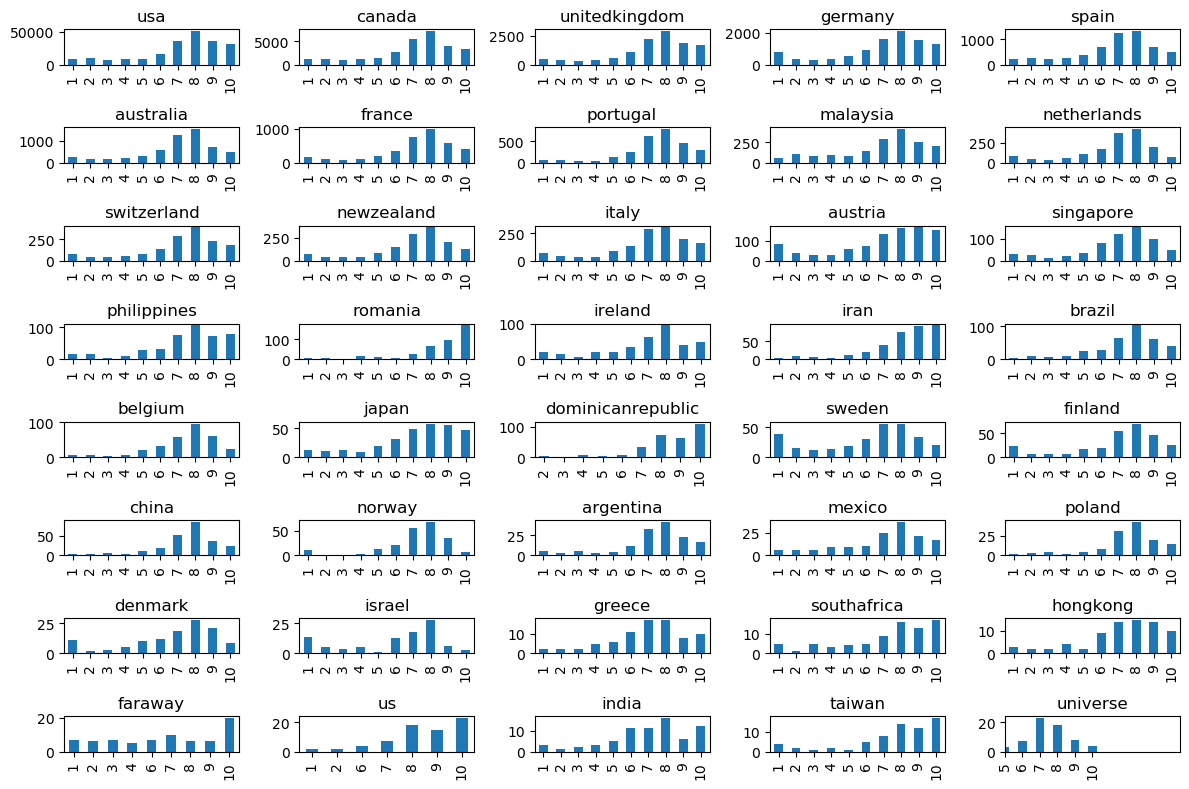

In [50]:
country_rating_count = pd.DataFrame(train_df.groupby('location_country')['rating'].count())
top_40_ctry = country_rating_count.rating.sort_values(ascending=False)[:40].index

fig, ax = plt.subplots(8,5,figsize=(12,8))
for country, ax_ in zip(top_40_ctry, ax.flatten()):
    train_df[train_df['location_country'] == country]['rating'].value_counts().sort_index().plot(ax=ax_, title=country, kind='bar')
    # users[(users['location_country']==country)]['age'].value_counts().sort_index().plot(ax=ax_, title=country)
plt.xlim(0,10)
plt.tight_layout()
plt.show()

- 상위 40개만 뽑아봤는데 꽤 연관이 없는듯 있어보이기도 한다?
- 특정 나라의 경우 분포가 다르기도 함
- ex) 스웨덴, 핀란드, 오스트리아, 덴마크...는 1점의 비율이 높고 1점이 거의 존재하지 않는 나라들도 있고

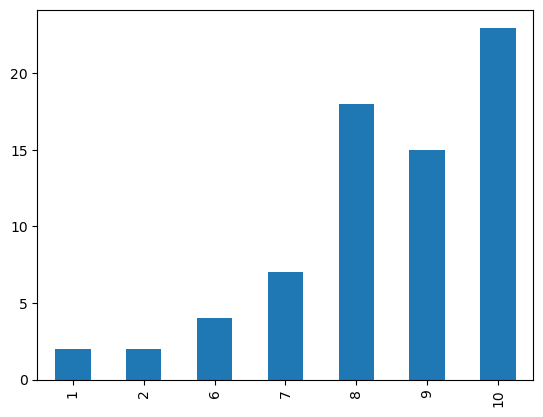

In [135]:
train_df[train_df['location_country'] == 'us']['rating'].value_counts().sort_index().plot(kind='bar');

In [56]:
train_age_nn = train_df[train_df['age'].notnull()]
train_age_nn

,user_id,isbn,rating,age,location_city,location_state,location_country,category,publisher,language,book_author
1,67544,0002005018,7,30.0,toronto,ontario,canada,['Actresses'],HarperFlamingo Canada,en,Richard Bruce Wright
5,219008,0002005018,7,60.0,halifax,novascotia,canada,['Actresses'],HarperFlamingo Canada,en,Richard Bruce Wright
6,263325,0002005018,5,27.0,fredericton,newbrunswick,canada,['Actresses'],HarperFlamingo Canada,en,Richard Bruce Wright
7,2954,0060973129,8,71.0,wichita,kansas,usa,['1940-1949'],HarperPerennial,en,Carlo D'Este
8,35704,0374157065,6,53.0,kansascity,missouri,usa,['Medical'],Farrar Straus Giroux,en,Gina Bari Kolata
...,...,...,...,...,...,...,...,...,...,...,...
306790,278843,0743525493,7,28.0,pismobeach,california,usa,NaN,Simon & Schuster Audio,NaN,David Gardner
306791,278851,067161746X,6,33.0,dallas,texas,usa,['Humor'],Pocket Books,en,P.J. O'Rourke
306792,278851,0884159221,7,33.0,dallas,texas,usa,NaN,Lone Star Books,NaN,Claude Dooley
306793,278851,0912333022,7,33.0,dallas,texas,usa,['Fiction'],Kqed Books,en,Jeremy Lloyd


#### age 별 rating 비교 (전처리 전)

In [58]:
train_age_nn['age_c'] = train_age_nn['age']//10

/tmp/ipykernel_20330/2052953983.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_age_nn['age_c'] = train_age_nn['age']//10


In [62]:
train_age_nn['age_c'].min(), train_age_nn['age_c'].max()

(0.0, 9.0)

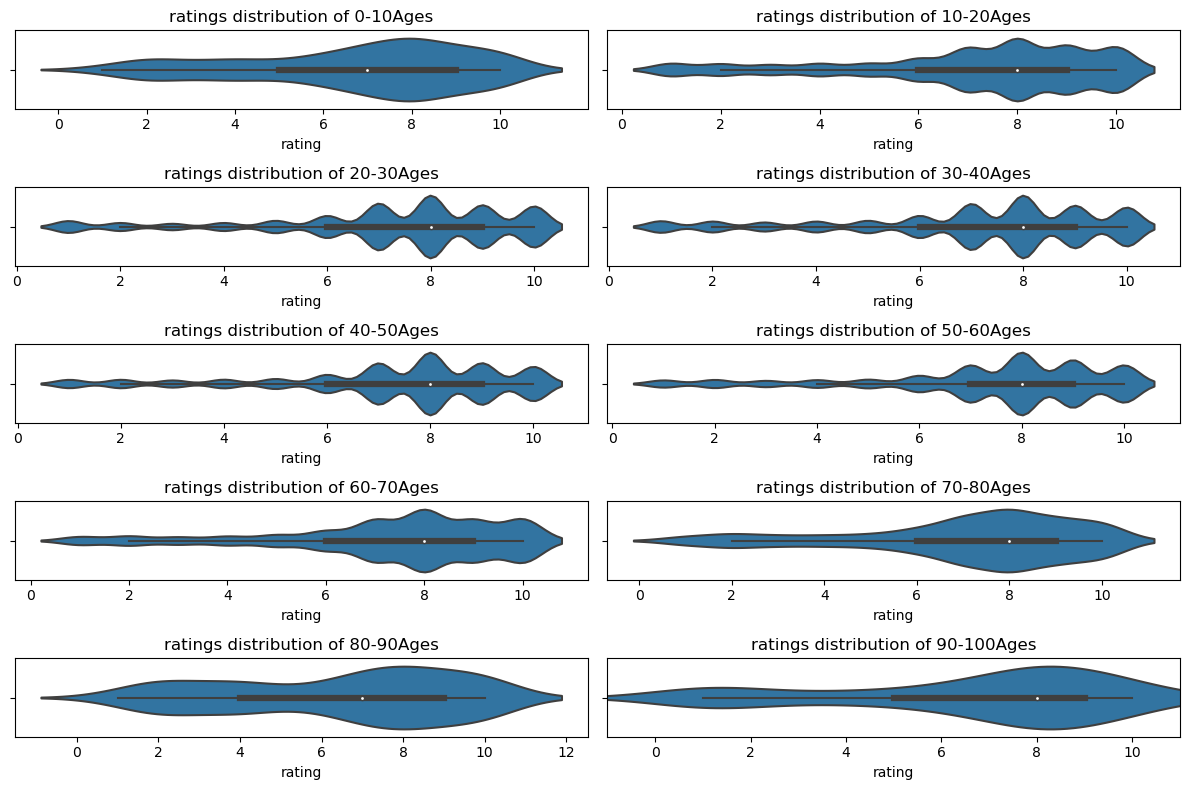

In [87]:
fig, ax = plt.subplots(5,2,figsize=(12,8))
for age, ax_ in zip(range(10), ax.flatten()):
    sns.violinplot(ax = ax_, x="rating", data=train_age_nn[train_age_nn['age_c']==age]).set(title = f'ratings distribution of {age*10}-{age*10 + 10}Ages')
plt.xlim(-1,11)
plt.tight_layout()
plt.show()

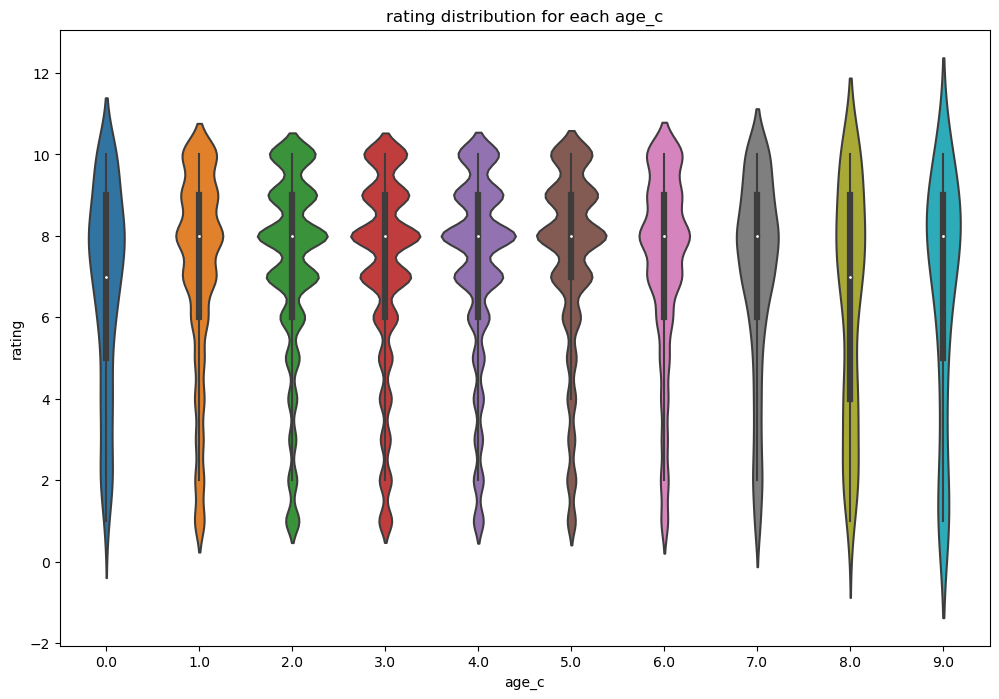

In [71]:
plt.figure(figsize = (12,8))
sns.violinplot(x="age_c", y='rating', data=train_age_nn)
plt.title('rating distribution for each age_c')
plt.show()

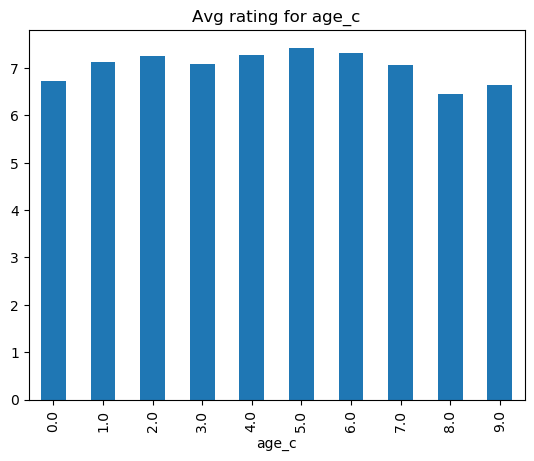

In [80]:
train_age_nn.groupby('age_c').mean()['rating'].plot(kind='bar')
plt.title('Avg rating for age_c')
plt.show()

- 연령대별 특성이 도드라지는 특정 연령대가 있다 (8-90대 or 10대)
- 연령대가 생각보다 중요한 역할을 할 수도 있을 것 같다

In [ ]:
# 인덱싱 처리
loc_city2idx = {v:k for k,v in enumerate(context_df['location_city'].unique())}
loc_state2idx = {v:k for k,v in enumerate(context_df['location_state'].unique())}
loc_country2idx = {v:k for k,v in enumerate(context_df['location_country'].unique())}

train_df['location_city'] = train_df['location_city'].map(loc_city2idx)
train_df['location_state'] = train_df['location_state'].map(loc_state2idx)
train_df['location_country'] = train_df['location_country'].map(loc_country2idx)
test_df['location_city'] = test_df['location_city'].map(loc_city2idx)
test_df['location_state'] = test_df['location_state'].map(loc_state2idx)
test_df['location_country'] = test_df['location_country'].map(loc_country2idx)

train_df['age'] = train_df['age'].fillna(int(train_df['age'].mean()))
train_df['age'] = train_df['age'].apply(age_map)
test_df['age'] = test_df['age'].fillna(int(test_df['age'].mean()))
test_df['age'] = test_df['age'].apply(age_map)

# book 파트 인덱싱
category2idx = {v:k for k,v in enumerate(context_df['category'].unique())}
publisher2idx = {v:k for k,v in enumerate(context_df['publisher'].unique())}
language2idx = {v:k for k,v in enumerate(context_df['language'].unique())}
author2idx = {v:k for k,v in enumerate(context_df['book_author'].unique())}

train_df['category'] = train_df['category'].map(category2idx)
train_df['publisher'] = train_df['publisher'].map(publisher2idx)
train_df['language'] = train_df['language'].map(language2idx)
train_df['book_author'] = train_df['book_author'].map(author2idx)
test_df['category'] = test_df['category'].map(category2idx)
test_df['publisher'] = test_df['publisher'].map(publisher2idx)
test_df['language'] = test_df['language'].map(language2idx)
test_df['book_author'] = test_df['book_author'].map(author2idx)

idx = {
    "loc_city2idx":loc_city2idx,
    "loc_state2idx":loc_state2idx,
    "loc_country2idx":loc_country2idx,
    "category2idx":category2idx,
    "publisher2idx":publisher2idx,
    "language2idx":language2idx,
    "author2idx":author2idx,
}

    # return idx, train_df, test_df